In [1]:
from glob import glob
import numpy as np
import paprika
import matplotlib.pyplot as plt
import pandas as pd

## Functions

Get SEM from blocking analysis

In [3]:
def block_sem(data):
    avgs = np.mean(data)
    totn = data.size
    blkn = paprika.analysis.get_nearest_max(totn)
    sems = paprika.analysis.get_block_sem(data[:blkn])
    
    return [avgs, sems]

Extract potential energy from Amber *.mden file

In [ ]:
def get_energies_for_enthalpy(mden):
    """
    Modeled after Niel's version
    """
    vdw = []
    ele = []
    bnd = []
    ang = []
    dih = []
    v14 = []
    e14 = []
    
    with open(mden, "r") as f:
        for line in f.readlines()[10:]:
            words = line.rstrip().split()
            if words[0] == "L6":
                vdw.append(float(words[3]))
                ele.append(float(words[4]))
            elif words[0] == "L7":
                bnd.append(float(words[2]))
                ang.append(float(words[3]))
                dih.append(float(words[4]))
            elif words[0] == "L8":
                v14.append(float(words[1]))
                e14.append(float(words[2]))
                
    return bnd, ang, dih, v14, e14, vdw, ele

## Initialize

In [2]:
n_blocks = 200
block_time = 5.0
n_ave = np.array([i+1 for i in range(n_blocks)])
frames = n_ave*block_time

## Bound potential energy

OpenMM Output

In [4]:
bound_cummulative = []
bound_potential_energy = []
for i in range(n_blocks):
    data = pd.read_csv(f'windows/a000/production-v{i+1}.log')
    bound_potential_energy.append(list(data['Potential Energy (kJ/mole)'].values))
    bound_cummulative.append(data['Potential Energy (kJ/mole)'].mean())

bound_potential_energy = np.array(bound_potential_energy).reshape(-1) / 4.184
bound_cummulative = np.array(bound_cummulative)
bound_cummulative = np.cumsum(bound_cummulative) / n_ave / 4.184

Amber Output

In [ ]:
e_bond = []
e_ang = []
e_dih = []
e_v14 = []
e_e14 = []
e_vdw = []
e_ele = []
for i in range(1):
    bnd, ang, dih, v14, e14, vdw, ele = get_energies_for_enthalpy(f'windows/a000/production-v{i+1}.mden')
    e_bond.append(bnd)
    e_ang.append(ang)
    e_dih.append(dih)
    e_v14.append(v14)
    e_e14.append(e14)
    e_vdw.append(vdw)
    e_ele.append(ele)

e_bond = [item for sublist in e_bond for item in sublist]
e_ang = [item for sublist in e_ang for item in sublist]
e_dih = [item for sublist in e_dih for item in sublist]
e_v14 = [item for sublist in e_v14 for item in sublist]
e_e14 = [item for sublist in e_e14 for item in sublist]
e_vdw = [item for sublist in e_vdw for item in sublist]
e_ele = [item for sublist in e_ele for item in sublist]

lists = [e_bond, e_ang, e_dih, e_v14, e_e14, e_vdw, e_ele]
e_total = [sum(x) for x in zip(*lists)]

bound_potential_energy = np.array(e_total)

## Unbound potential energy

OpenMM Output

In [5]:
unbound_cummulative = []
unbound_potential_energy = []
for i in range(n_blocks):
    data = pd.read_csv(f'windows/r014/production-v{i+1}.log')
    unbound_potential_energy.append(list(data['Potential Energy (kJ/mole)'].values))
    unbound_cummulative.append(data['Potential Energy (kJ/mole)'].mean())
    
unbound_potential_energy = np.array(unbound_potential_energy).reshape(-1) / 4.184
unbound_cummulative = np.array(unbound_cummulative)
unbound_cummulative = np.cumsum(unbound_cummulative) / n_ave / 4.184

Amber Output

In [ ]:
e_bond = []
e_ang = []
e_dih = []
e_v14 = []
e_e14 = []
e_vdw = []
e_ele = []
for i in range(1):
    bnd, ang, dih, v14, e14, vdw, ele = get_energies_for_enthalpy(f'windows/r014/production-v{i+1}.mden')
    e_bond.append(bnd)
    e_ang.append(ang)
    e_dih.append(dih)
    e_v14.append(v14)
    e_e14.append(e14)
    e_vdw.append(vdw)
    e_ele.append(ele)

e_bond = [item for sublist in e_bond for item in sublist]
e_ang = [item for sublist in e_ang for item in sublist]
e_dih = [item for sublist in e_dih for item in sublist]
e_v14 = [item for sublist in e_v14 for item in sublist]
e_e14 = [item for sublist in e_e14 for item in sublist]
e_vdw = [item for sublist in e_vdw for item in sublist]
e_ele = [item for sublist in e_ele for item in sublist]

lists = [e_bond, e_ang, e_dih, e_v14, e_e14, e_vdw, e_ele]
e_total = [sum(x) for x in zip(*lists)]

unbound_potential_energy = np.array(e_total)

## Enthalpy

In [6]:
bound = block_sem(bound_potential_energy)
unbound = block_sem(unbound_potential_energy)
enthalpy = {'pe': bound[0] - unbound[0], 'sem': (bound[1]**2 + unbound[1]**2)**0.5}
print(f"Bound potential energy  : {bound[0]:.2f} +- {bound[1]:.2f} kcal/mol")
print(f"Unbound potential energy: {bound[0]:.2f} +- {bound[1]:.2f} kcal/mol")
print(f"Binding Enthalpy        : {enthalpy['pe']:.2f} +- {enthalpy['sem']:.2f} kcal/mol")

Bound potential energy  : -18136.02 +- 0.22 kcal/mol
Unbound potential energy: -18136.02 +- 0.22 kcal/mol
Binding Enthalpy        : -25.92 +- 0.32 kcal/mol


## Plot results

Text(0.5, 0, 'Time (ns)')

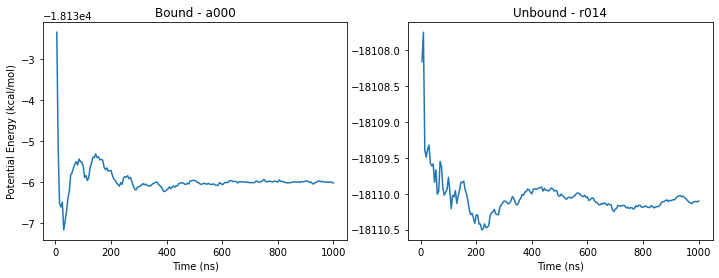

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(frames, bound_cummulative, label='bound')
plt.title('Bound - a000')
plt.xlabel('Time (ns)')
plt.ylabel('Potential Energy (kcal/mol)')

plt.subplot(1,2,2)
plt.plot(frames, unbound_cummulative, label='unbound')
plt.title('Unbound - r014')
plt.xlabel('Time (ns)')